<a href="https://colab.research.google.com/github/G0nkly/Ready-Set-Prophecy/blob/main/Timeseries_Intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost --quiet
!pip install lightgbm --quiet
!pip install prophet --quiet

# **Data Generation and Preparation**

#### **Synthetic Dataset**

In [ ]:
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Reproduzierbarkeit
np.random.seed(42)

# Zeitachse: 2 Jahre tägliche Daten
dates = pd.date_range(start="2022-01-01", end="2023-12-31", freq="D")
n = len(dates)

# Komponenten
base_level = 900
trend = np.linspace(0, 50, n)
weekly_seasonality = 40 * np.sin(2 * np.pi * dates.dayofweek / 7)
noise = np.random.normal(0, 15, n)

# Verbrauch
consumption = base_level + trend + weekly_seasonality + noise

# DataFrame
df = pd.DataFrame({
    "date": dates,
    "consumption_mwh": consumption
})

# Als CSV speichern
df.to_csv("consumption_daily.csv", index=False)

df.head()

,date,consumption_mwh
0,2022-01-01,868.453596
1,2022-01-02,866.721363
2,2022-01-03,909.852502
3,2022-01-04,954.324468
4,2022-01-05,935.759164


#### **Data Visualization**

In [ ]:
df = pd.read_csv("consumption_daily.csv", parse_dates=["date"])
df = df.set_index("date")

df.head()

,consumption_mwh
date,
2022-01-01,868.453596
2022-01-02,866.721363
2022-01-03,909.852502
2022-01-04,954.324468
2022-01-05,935.759164


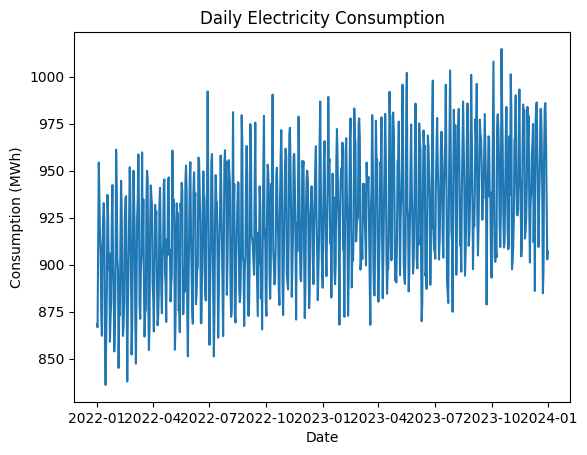

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(df.index, df["consumption_mwh"])
plt.title("Daily Electricity Consumption")
plt.xlabel("Date")
plt.ylabel("Consumption (MWh)")
plt.show()


# **ARIMA vs SARIMA vs ETS**

## **ARIMMA/SARIMA**

**What it is**

* Linear autoregressive models that explain a time series using:

* its own past values (AR)

* past errors (MA)

* differencing to remove trends (I)

* **SARIMA** adds explicit seasonality

**What makes it special**

* Fully statistical

* Interpretable

* Works directly on the time series

* Very strong for stable, structured patterns

**When to use**

* Clear trend + seasonality

* Short to medium forecast horizon

* Limited data

* Need interpretability / explainability

**Where it struggles**

* Multiple seasonalities

* Nonlinear effects

* Sudden regime changes

* External drivers (weather, prices)

**Energy interview angle**

*“SARIMA is often a strong baseline for load or generation forecasting with stable seasonal patterns.”*

## **ETS (Error-Trend-Seasonality)**

**What it is**

Exponential smoothing model that decomposes time series into:

* Level

* Trend

* Seasonality

**What makes it special**

* Very robust

* Fast

* Fewer assumptions than ARIMA

* Handles changing trends smoothly

**When to use**

* Smooth demand signals

* Strong recurring seasonality

* Need a reliable baseline fast

**Where it struggles**

* No external features

* Limited expressiveness

* Not ideal for long horizons with regime shifts

**Energy interview angle**

*“ETS is often a great benchmark for demand forecasting before moving to ML.”*

#### **Train / Test split**

In [ ]:
train = df.iloc[:-30]
test = df.iloc[-30:]

print("Train:", train.shape)
print("Test:", test.shape)

Train: (700, 1)
Test: (30, 1)


#### **Model Training and Forecast (ARIMA)**

In [ ]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

arima = SARIMAX(
    train["consumption_mwh"],
    order=(1, 1, 1)
)

arima_fit = arima.fit(disp=False)

arima_forecast = arima_fit.forecast(30)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


#### **Model Training and Forecast (SARIMA)**

In [ ]:
sarima = SARIMAX(
    train["consumption_mwh"],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 7)
)

sarima_fit = sarima.fit(disp=False)

sarima_forecast = sarima_fit.forecast(30)

/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


#### **Model Training and Forecast (ETS)**

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

ets = ExponentialSmoothing(
    train["consumption_mwh"],
    trend="add",
    seasonal="add",
    seasonal_periods=7
)

ets_fit = ets.fit()

ets_forecast = ets_fit.forecast(30)

#### **Evaluation**

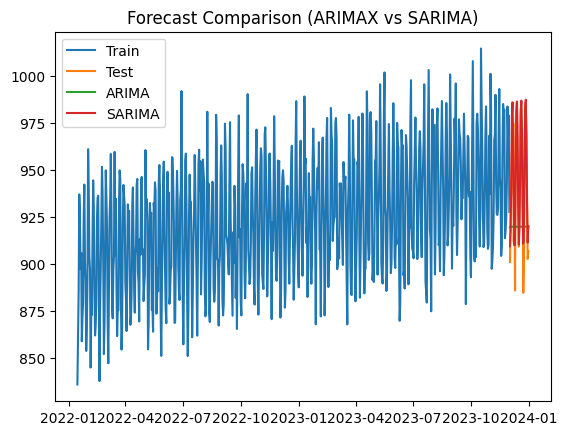

In [ ]:
plt.figure()

plt.plot(train.index, train["consumption_mwh"], label="Train")
plt.plot(test.index, test["consumption_mwh"], label="Test")

plt.plot(test.index, arima_forecast, label="ARIMA")
plt.plot(test.index, sarima_forecast, label="SARIMA")

plt.title("Forecast Comparison (ARIMAX vs SARIMA)")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_forecast(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    return rmse, mae, mape

# ARIMA
arima_rmse, arima_mae, arima_mape = evaluate_forecast(test["consumption_mwh"], arima_forecast)

# SARIMA
sarima_rmse, sarima_mae, sarima_mape = evaluate_forecast(test["consumption_mwh"], sarima_forecast)

# ETS
ets_rmse, ets_mae, ets_mape = evaluate_forecast(test["consumption_mwh"], ets_forecast)

print("ARIMA: RMSE {:.2f}, MAE {:.2f}, MAPE {:.2f}%".format(arima_rmse, arima_mae, arima_mape))
print("SARIMA: RMSE {:.2f}, MAE {:.2f}, MAPE {:.2f}%".format(sarima_rmse, sarima_mae, sarima_mape))
print("ETS: RMSE {:.2f}, MAE {:.2f}, MAPE {:.2f}%".format(ets_rmse, ets_mae, ets_mape))

ARIMA: RMSE 40.03, MAE 34.98, MAPE 3.65%
SARIMA: RMSE 14.52, MAE 11.22, MAPE 1.21%
ETS: RMSE 14.51, MAE 11.18, MAPE 1.20%


# **Prophet**

**What it is**
An additive model:

```
y(t) = trend + seasonality + holidays + noise
```

**What makes it special**

* Trend modeled as piecewise linear or logistic

* Seasonality via Fourier series

* Handles missing data, outliers

* Works directly on the time series

**Important clarification**

❗ Prophet does not automatically discover everything

* You must enable seasonality types

* You must tell it about holidays / events

**When to use**

* Business time series

* Strong calendar effects

* Need robustness + speed

* Medium interpretability

**Where it struggles**

* Complex nonlinear interactions

* Many external drivers

* Very high-frequency signals

**Energy interview angle**

*“Prophet is well suited for operational forecasting with calendar effects and moderate complexity.”*

#### **Data Preparation**

In [ ]:
df = pd.read_csv("consumption_daily.csv", parse_dates=["date"])
df_prophet = df.rename(columns={"date": "ds", "consumption_mwh": "y"})

#### **Model Training and Forecast**

In [ ]:
from prophet import Prophet

model_prophet = Prophet(daily_seasonality=False, weekly_seasonality=True, yearly_seasonality=True)
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=30)
forecast = model_prophet.predict(future)

#### **Evaluation**

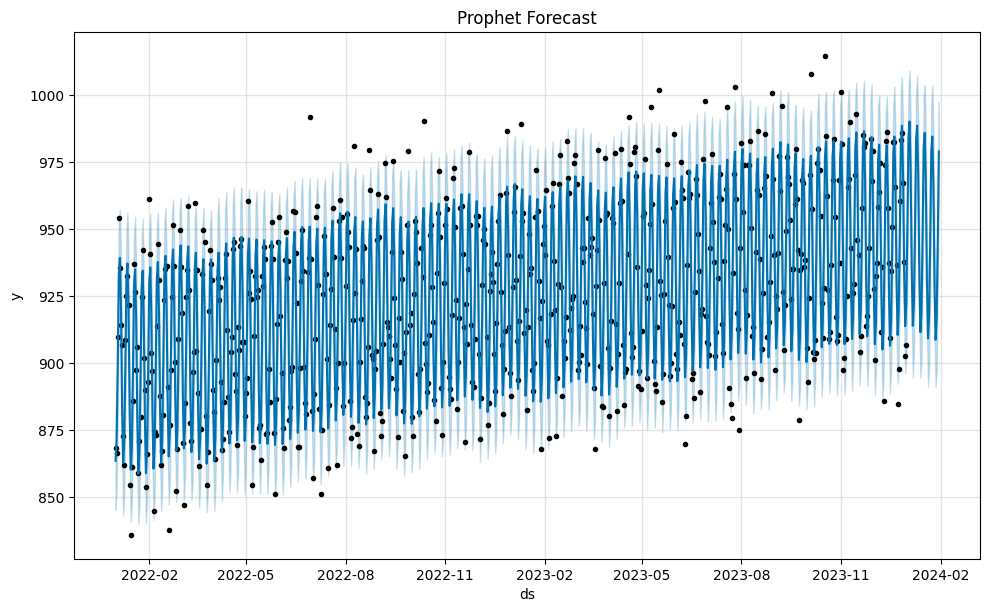

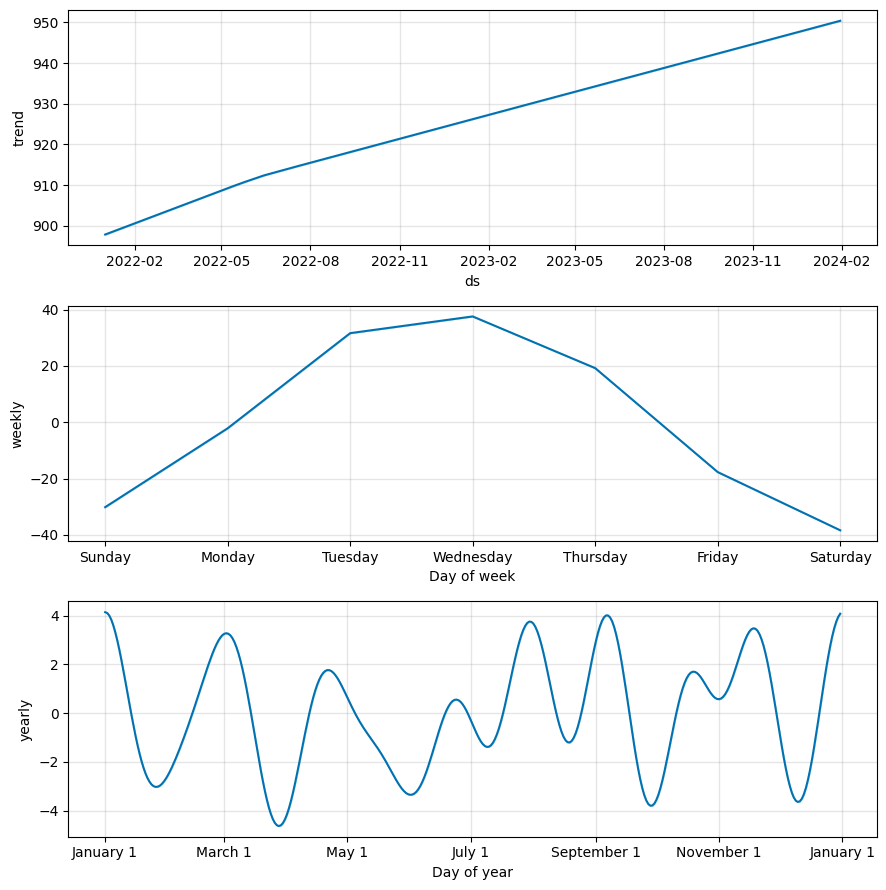

In [ ]:
fig1 = model_prophet.plot(forecast)
plt.title("Prophet Forecast")
plt.show()

fig2 = model_prophet.plot_components(forecast)
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Prophet Forecast auf Testperiode beschränken
prophet_test = forecast.set_index("ds").loc[y_test.index]["yhat"]

# Metriken
prophet_rmse = np.sqrt(mean_squared_error(y_test, prophet_test))
prophet_mae = mean_absolute_error(y_test, prophet_test)
prophet_mape = np.mean(np.abs((y_test - prophet_test) / y_test)) * 100

print("Prophet Evaluation")
print(f"RMSE: {prophet_rmse:.2f}")
print(f"MAE:  {prophet_mae:.2f}")
print(f"MAPE: {prophet_mape:.2f}%")


Prophet Evaluation
RMSE: 14.68
MAE:  11.62
MAPE: 1.25%


# **Gradient Boosting / XGBoost / LightGBM**


**What it is**

Tree-based ensemble models trained on engineered features.

**Key difference vs classical models**
❗ They do not understand time
→ You must create it via features.

**Typical features**

* Lags (t-1, t-24, t-168)

* Rolling statistics

* Calendar features

* Weather features

* Prices, holidays

**What makes them special**

* Capture nonlinearities

* Combine many signals

* Excellent accuracy

* Fast training and inference

**When to use**

* Many external drivers

* Medium to large datasets

* Need strong predictive performance

* Forecast feeds optimization

**Where they struggle**

* Long horizons without good features

* Concept drift if not monitored

* Need careful leakage control

**Energy interview angle**

*“Gradient boosting is often the workhorse model for load or price forecasting when exogenous features are available.”*

### **XGBoost**
XGBoost vs standard gradient boosting:

**Functionality**
*   L1 (Lasso Regression, simplifies the model by removing less important features) and L2(Ridge Regression, balances influence of different features)
*   Tree pruning (limit the depth of decision trees - avoid complex models)
*   Parallel Processing
*   XBoost can handle missing data automatically

**Point of use**
*   Tabular Data, Large Datasets (Parallelization!)
*   Feature Importance - built-in feature importance scores
*   Hyperparameters for handling imbalanced datasets

**Competitors**
*   LightGBM (histogram-based, supports GPU)
*   CatBoost (good for categorical features)


### **Forecast with XGBoost**

#### **Data Retrieval and Feature engineering**




In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("consumption_daily.csv", parse_dates=["date"])
df = df.set_index("date")

# Kalenderfeatures
df["day_of_week"] = df.index.dayofweek
df["weekend"] = (df["day_of_week"] >= 5).astype(int)
df["month"] = df.index.month

# Lag-Features
df["lag_1"] = df["consumption_mwh"].shift(1)
df["lag_7"] = df["consumption_mwh"].shift(7)
df["lag_14"] = df["consumption_mwh"].shift(14)

# Rolling Statistics
df["rolling_mean_7"] = df["consumption_mwh"].rolling(7).mean()
df["rolling_std_7"] = df["consumption_mwh"].rolling(7).std()

df = df.dropna()
df.head()

,consumption_mwh,day_of_week,weekend,month,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7
date,,,,,,,,,
2022-01-15,836.089336,5,1,1,854.837079,872.994514,868.453596,891.642392,39.397251
2022-01-16,861.321234,6,1,1,836.089336,862.233322,866.721363,891.512094,39.512067
2022-01-17,885.904927,0,0,1,861.321234,908.755685,909.852502,888.247700,38.787295
2022-01-18,937.152950,1,0,1,885.904927,925.007865,954.324468,889.982712,40.918756
2022-01-19,926.611323,2,0,1,937.152950,932.765628,935.759164,889.103525,39.899737


#### **Train / Test split**

In [ ]:
train = df.iloc[:-30]
test = df.iloc[-30:]

X_train = train.drop("consumption_mwh", axis=1)
y_train = train["consumption_mwh"]

X_test = test.drop("consumption_mwh", axis=1)
y_test = test["consumption_mwh"]

#### **Model Training and forecast**

In [ ]:
from xgboost import XGBRegressor

xgb = XGBRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

xgb.fit(X_train, y_train)

xgb_forecast = xgb.predict(X_test)

#### **Evaluation**

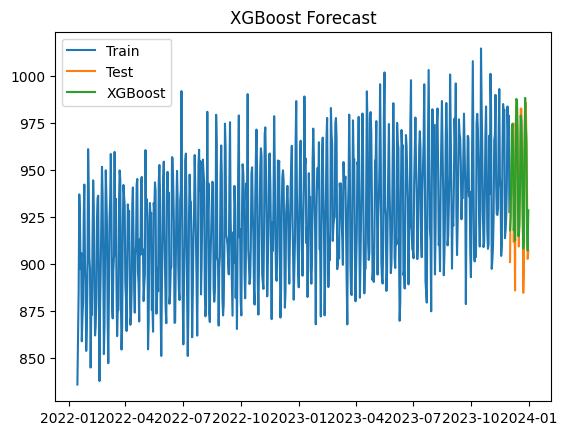

In [ ]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(train.index, train["consumption_mwh"], label="Train")
plt.plot(test.index, y_test, label="Test")
plt.plot(test.index, xgb_forecast, label="XGBoost")

plt.title("XGBoost Forecast")
plt.legend()
plt.show()

In [ ]:
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_forecast))
xgb_mae = mean_absolute_error(y_test, xgb_forecast)
xgb_mape = np.mean(np.abs((y_test - xgb_forecast) / y_test)) * 100

print("XGBoost Evaluation")
print(f"RMSE: {xgb_rmse:.2f}")
print(f"MAE:  {xgb_mae:.2f}")
print(f"MAPE: {xgb_mape:.2f}%\n")

XGBoost Evaluation
RMSE: 13.08
MAE:  11.12
MAPE: 1.19%



#### **Feature Importance**

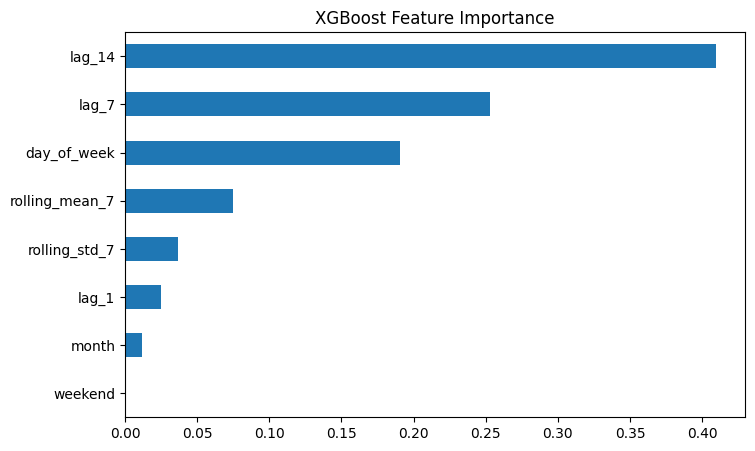

In [ ]:
importance = xgb.feature_importances_
features = X_train.columns

fi = pd.Series(importance, index=features).sort_values(ascending=False)

fi.plot(kind="barh", figsize=(8,5))
plt.title("XGBoost Feature Importance")
plt.gca().invert_yaxis()
plt.show()


# **LightGBM**

#### **Data Retrieval and Feature engineering**




In [ ]:
import pandas as pd
import numpy as np

df = pd.read_csv("consumption_daily.csv", parse_dates=["date"])
df = df.set_index("date")

# Kalenderfeatures
df["day_of_week"] = df.index.dayofweek
df["weekend"] = (df["day_of_week"] >= 5).astype(int)
df["month"] = df.index.month

# Lag-Features
df["lag_1"] = df["consumption_mwh"].shift(1)
df["lag_7"] = df["consumption_mwh"].shift(7)
df["lag_14"] = df["consumption_mwh"].shift(14)

# Rolling Statistics
df["rolling_mean_7"] = df["consumption_mwh"].rolling(7).mean()
df["rolling_std_7"] = df["consumption_mwh"].rolling(7).std()

df = df.dropna()
df.head()

,consumption_mwh,day_of_week,weekend,month,lag_1,lag_7,lag_14,rolling_mean_7,rolling_std_7
date,,,,,,,,,
2022-01-15,836.089336,5,1,1,854.837079,872.994514,868.453596,891.642392,39.397251
2022-01-16,861.321234,6,1,1,836.089336,862.233322,866.721363,891.512094,39.512067
2022-01-17,885.904927,0,0,1,861.321234,908.755685,909.852502,888.247700,38.787295
2022-01-18,937.152950,1,0,1,885.904927,925.007865,954.324468,889.982712,40.918756
2022-01-19,926.611323,2,0,1,937.152950,932.765628,935.759164,889.103525,39.899737


#### **Train / Test split**

In [ ]:
train = df.iloc[:-30]
test = df.iloc[-30:]

X_train = train.drop("consumption_mwh", axis=1)
y_train = train["consumption_mwh"]

X_test = test.drop("consumption_mwh", axis=1)
y_test = test["consumption_mwh"]

#### **Model training and Forecast**

In [ ]:
from lightgbm import LGBMRegressor

params = {'verbose': -1}
lgbm = LGBMRegressor(
    verbose=-1,
    n_estimators=200,
    learning_rate=0.05,
    max_depth=5,
    random_state=42
)

lgbm.fit(X_train, y_train)

lgbm_forecast = lgbm.predict(X_test)

#### **Evaluation**

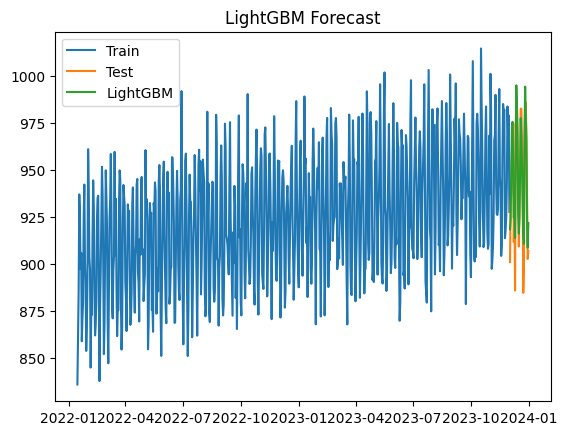

In [ ]:
import matplotlib.pyplot as plt

plt.figure()

plt.plot(train.index, train["consumption_mwh"], label="Train")
plt.plot(test.index, y_test, label="Test")
plt.plot(test.index, lgbm_forecast, label="LightGBM")

plt.title("LightGBM Forecast")
plt.legend()
plt.show()

In [ ]:
lgbm_rmse = np.sqrt(mean_squared_error(y_test, lgbm_forecast))
lgbm_mae = mean_absolute_error(y_test, lgbm_forecast)
lgbm_mape = np.mean(np.abs((y_test - lgbm_forecast) / y_test)) * 100

print("LightGBM Evaluation")
print(f"RMSE: {lgbm_rmse:.2f}")
print(f"MAE:  {lgbm_mae:.2f}")
print(f"MAPE: {lgbm_mape:.2f}%")

LightGBM Evaluation
RMSE: 13.79
MAE:  11.95
MAPE: 1.28%


# **Model Comparison (all models)**


In [ ]:
results = pd.DataFrame({
    "Model": ["Prophet", "XGBoost", "LightGBM", "ETS", "SARIMA", "ARIMA"],
    "RMSE": [prophet_rmse, xgb_rmse, lgbm_rmse, ets_rmse, sarima_rmse, arima_rmse],
    "MAE": [prophet_mae, xgb_mae, lgbm_mae, ets_mae, sarima_mae, arima_mae],
    "MAPE (%)": [prophet_mape, xgb_mape, lgbm_mape, ets_mape, sarima_mape, arima_mape]
})

results

,Model,RMSE,MAE,MAPE (%)
0,Prophet,14.680781,11.619493,1.245279
1,XGBoost,13.077365,11.120015,1.191628
2,LightGBM,13.787749,11.946707,1.275873
3,ETS,14.505860,11.183766,1.201775
4,SARIMA,14.516889,11.215144,1.205050
5,ARIMA,40.033471,34.977280,3.653239


# **Deep Learning Models (Sequence Models - LSTM)**

**What it is**
Recurrent neural network with memory cells.

**What makes it special**

* Learns temporal dependencies automatically

* Handles nonlinear dynamics

* No manual lag selection required

**When to use**

* Complex temporal dynamics

* Large datasets

* Research-heavy or high-value use cases

**Where it struggles**

* Hard to interpret

* Sensitive to hyperparameters

* Often beaten by boosted trees in practice

**Energy interview angle**

*“LSTMs are useful for complex temporal patterns but often require significant tuning.”*

# **Temporal Fusion Transformer (TFT)**

**What it is**

State-of-the-art deep learning architecture for time series.

**What makes it special**

* Attention mechanism

* Handles static + time-varying features

* Produces quantile forecasts

* Built-in interpretability

**When to use**

* Large-scale forecasting

* Many correlated time series

* Need uncertainty estimates

**Where it struggles**

* Heavy infrastructure

* Complex training

* Overkill for small problems

**Energy interview angle**

*“TFT is well suited for large-scale forecasting across assets with uncertainty quantification.”*

# **Summary**

## **Evalution**

* Metrics

| Metric       | When to use                                   |
| ------------ | --------------------------------------------- |
| RMSE         | Penalize large errors                         |
| MAE          | Robust to outliers                            |
| MAPE         | Business interpretability (careful near zero) |
| Pinball loss | Quantile / uncertainty forecasts              |

* Validation Strategy
  * Rolling Forecast Origin
  * No random splits
  * Watch for data leakage

## **Drifts**
* Concept Drift: relationship between the input features (x) and the target variable (y) changes over time
* Data Drift; distribution of the input features (x) changes over time


## **Model Guide**
* ARIMA / ETS → structured, stable signals

* Prophet → business time series with calendar effects

* XGBoost / LightGBM → multiple drivers, high accuracy

* LSTM → complex temporal dependencies

* TFT → large-scale, probabilistic forecasting